In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(pbapply)
suppressPackageStartupMessages(require(plotly))
require(viridis)
pboptions(type="timer")

source("../manuscript/functions/save_and_plot.R")

Loading required package: cowplot

Loading required package: data.table

Loading required package: ggplot2

Loading required package: pbapply

Loading required package: viridis

Loading required package: viridisLite



In [2]:
root_path = "../data/3D_David/"
#list.files(file.path(root_path))
#list.files(file.path(root_path, "DW_models"))

In [3]:
probe_meta = fread(file.path(root_path, "probes_chrX46.csv"))
#head(probe_meta)

hic_matrix = fread(file.path(root_path, "mat_hic_46plex.csv"))
#hic_matrix[1:5, 1:5]

In [4]:
hic_data = as.data.table(expand.grid(1:45, 1:45))
setnames(hic_data, LETTERS[1:2])

In [5]:
hic_data$hic_freq = as.matrix(hic_matrix)[as.matrix(hic_data[, .(A, B)])]

In [6]:
coords_dw = rbindlist(pblapply(0:195, function(file_id) {
    coords = fread(file.path(root_path, "DW_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "DW_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

coords_rl = rbindlist(pblapply(0:175, function(file_id) {
    coords = fread(file.path(root_path, "RL_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "RL_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [7]:
smatch = fread("../data/3D_David/link_rois_RL_DW.csv")
match_vector = smatch[, .(id_DW, id_RL)]
dim(match_vector)

[1] 162   2

In [8]:
print(sprintf("Number of locations in DW: %d", coords_dw[, .N, by=file_id][, unique(N)]))
print(sprintf("Number of DW structures: %d", coords_dw[, .N, by=region][, unique(N)]))

print(sprintf("Number of locations in RL: %d", coords_rl[, .N, by=file_id][, unique(N)]))
print(sprintf("Number of RL structures: %d", coords_rl[, .N, by=region][, unique(N)]))

[1] "Number of locations in DW: 46"
[1] "Number of DW structures: 196"
[1] "Number of locations in RL: 46"
[1] "Number of RL structures: 176"


## Comparison of a handful of manually selected structures

In [9]:
plot_3d_structures = function(coords1, coords2, lab1, lab2) {
    sdata1 = coords1[, .(i, x, y, z, interpolated, file_id)]
    p1 = plot_ly(sdata1, x=~x, y=~y, z=~z, type="scatter3d", mode="lines+markers",
                line=list(width=1, color="blue"), marker=list(size=2, color="blue", colorscale="Viridis"))
    sdata2 = coords2[, .(i, x, y, z, interpolated, file_id)]
    p2 = plot_ly(sdata2, x=~x, y=~y, z=~z, type="scatter3d", mode="lines+markers",
                line=list(width=1, color="red"), marker=list(size=2, color="red", colorscale="Viridis"))
    options(repr.plot.width=24, repr.plot.height=24)
    fig = subplot(p1, p2)
    fig = fig %>% layout(title=sprintf("Blue: %s. Red: %s.", lab1, lab2))
    embed_notebook(fig, width="600px", height="600px")
}

In [10]:
plot_xy_structures = function(coords1, coords2, lab1, lab2) {
    options(repr.plot.width=12, repr.plot.height=6)
    p1 = ggplot(coords1[, .(i, x, y, interpolated, file_id)], aes(x, y, color=i, shape=factor(interpolated, levels=c(TRUE, FALSE)))) +
        geom_path(alpha=.2, color="black") + geom_point(size=2) + 
        theme_bw() + facet_wrap(~file_id, scales="free") + scale_color_viridis() +
        theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
        labs(title=lab1, shape="Interpolated")
    p2 = ggplot(coords2[, .(i, x, y, interpolated, file_id)], aes(x, y, color=i, shape=factor(interpolated, levels=c(TRUE, FALSE)))) +
        geom_path(alpha=.2, color="black") + geom_point(size=2) + 
        theme_bw() + facet_wrap(~file_id, scales="free") + scale_color_viridis() +
        theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
        labs(title=lab2, shape="Interpolated")
    plot_grid(p1, p2, nrow=1)
}

In [11]:
smatch = fread("../data/3D_David/link_rois_RL_DW.csv")

In [12]:
pl = pblapply(1:nrow(smatch), function(iii) {
    plot_xy_structures(coords_dw[file_id == smatch$id_DW[iii]+1], coords_rl[file_id == smatch$id_RL[iii]+1], "DW", "RL")   
}, cl=5)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=46s  


In [13]:
pdf("matched_structures.XY.pdf", width=10, height=5)
l=pblapply(pl, print)
graphics.off()

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=34s  


In [14]:
iii = 1
cdw = coords_dw[file_id == smatch$id_DW[iii]+1, .(x, y, z, status="DW")]
setkeyv(cdw, c("x", "y", "z"))
crl = coords_rl[file_id == smatch$id_RL[iii]+1, .(x, y, z, status="RL")]
setkeyv(crl, c("x", "y", "z"))
n = nrow(merge(cdw, crl, all=T)[!is.na(`status.x`) & !is.na(`status.y`)])

In [15]:
noverlap = rbindlist(pblapply(1:nrow(smatch), function(iii) {
    cdw = coords_dw[file_id == smatch$id_DW[iii]+1, .(x, y, z, status="DW")]
    crl = coords_rl[file_id == smatch$id_RL[iii]+1, .(x, y, z, status="RL")]
    setkeyv(cdw, c("x", "y", "z"))
    setkeyv(crl, c("x", "y", "z"))
    nxyz = nrow(merge(cdw, crl, all=T)[!is.na(`status.x`) & !is.na(`status.y`)])
    setkeyv(cdw, c("x", "y"))
    setkeyv(crl, c("x", "y"))
    nxy = nrow(merge(cdw, crl, all=T)[!is.na(`status.x`) & !is.na(`status.y`)])
    data.table(file_id=iii+1, n3d=nxyz, n2d=nxy)
}, cl=5))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09s  


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


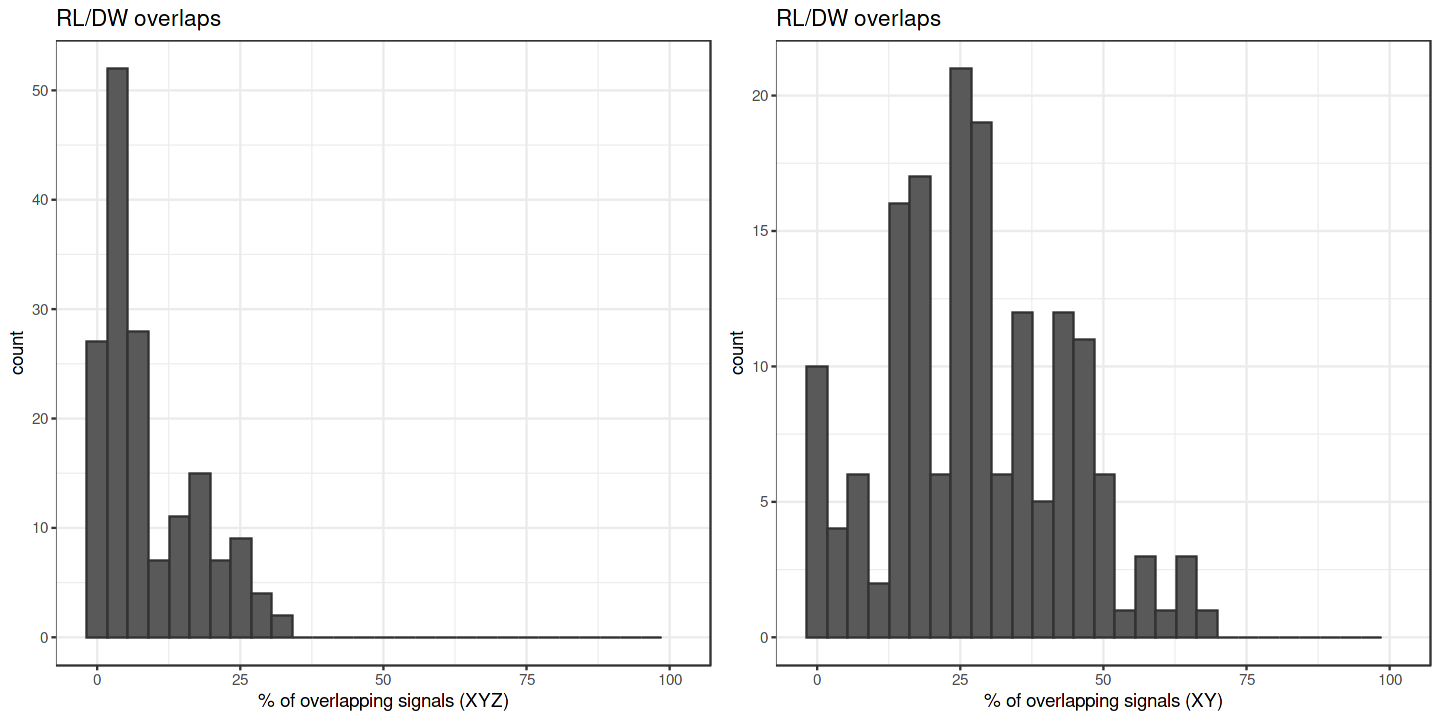

In [16]:
options(repr.plot.width=12, repr.plot.height=6)
p1 = ggplot(noverlap, aes(x=n3d/46*100)) + geom_histogram(color="#323232") + theme_bw() +
    labs(x="% of overlapping signals (XYZ)", title="RL/DW overlaps") + xlim(-2, 102)
p2 = ggplot(noverlap, aes(x=n2d/46*100)) + geom_histogram(color="#323232") + theme_bw() +
    labs(x="% of overlapping signals (XY)", title="RL/DW overlaps") + xlim(-2, 102)
plot_grid(p1, p2, nrow=1)

Warning message:
“'layout' objects don't have these attributes: 'NA'
Valid attributes include:
'font', 'title', 'uniformtext', 'autosize', 'width', 'height', 'margin', 'computed', 'paper_bgcolor', 'plot_bgcolor', 'separators', 'hidesources', 'showlegend', 'colorway', 'datarevision', 'uirevision', 'editrevision', 'selectionrevision', 'template', 'modebar', 'newshape', 'activeshape', 'meta', 'transition', '_deprecated', 'clickmode', 'dragmode', 'hovermode', 'hoverdistance', 'spikedistance', 'hoverlabel', 'selectdirection', 'grid', 'calendar', 'xaxis', 'yaxis', 'ternary', 'scene', 'geo', 'mapbox', 'polar', 'radialaxis', 'angularaxis', 'direction', 'orientation', 'editType', 'legend', 'annotations', 'shapes', 'images', 'updatemenus', 'sliders', 'colorscale', 'coloraxis', 'metasrc', 'barmode', 'bargap', 'mapType'
”
Warning message:
“'layout' objects don't have these attributes: 'NA'
Valid attributes include:
'font', 'title', 'uniformtext', 'autosize', 'width', 'height', 'margin', 'computed'

<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgo8aGVhZD4KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+Cjx0aXRsZT5wbG90bHk8L3RpdGxlPgo8c2NyaXB0IHNyYz0iZGF0YTphcHBsaWNhdGlvbi9qYXZhc2NyaXB0O2Jhc2U2NCxLR1oxYm1OMGFXOXVLQ2tnZXdvZ0lDOHZJRWxtSUhkcGJtUnZkeTVJVkUxTVYybGtaMlYwY3lCcGN5QmhiSEpsWVdSNUlHUmxabWx1WldRc0lIUm9aVzRnZFhObElHbDBPeUJ2ZEdobGNuZHBjMlVnWTNKbFlYUmxJR0VLSUNBdkx5QnVaWGNnYjJKcVpXTjBMaUJVYUdseklHRnNiRzkzY3lCd2NtVmpaV1JwYm1jZ1kyOWtaU0IwYnlCelpYUWdiM0IwYVc5dWN5QjBhR0YwSUdGbVptVmpkQ0IwYUdVS0lDQXZMeUJwYm1sMGFXRnNhWHBoZEdsdmJpQndjbTlqWlhOeklDaDBhRzkxWjJnZ2JtOXVaU0JqZFhKeVpXNTBiSGtnWlhocGMzUXBMZ29nSUhkcGJtUnZkeTVJVkUxTVYybGtaMlYwY3lBOUlIZHBibVJ2ZHk1SVZFMU1WMmxrWjJWMGN5QjhmQ0I3ZlRzS0NpQWdMeThnVTJWbElHbG1JSGRsSjNKbElISjFibTVwYm1jZ2FXNGdZU0IyYVdWM1pYSWdjR0Z1WlM0Z1NXWWdibTkwTENCM1pTZHlaU0JwYmlCaElIZGxZaUJpY205M2MyVnlMZ29nSUhaaGNpQjJhV1YzWlhKTmIyUmxJRDBnZDJsdVpHOTNMa2hVVFV4WGFXUm5aWFJ6TG5acFpYZGxjazF2WkdVZ1BRb2dJQ0FnSUNBdlhHSjJhV1YzWlhKZmNHRnVaVDB4WEdJdkxuUmxjM1FvZDJsdVpHOTNMbXh2WTJGMGFXOXVLVHNLQ2lBZ0x5OGdVMlZsSUdsbUlIZGxKM0psSUhKMWJtNXBibWNnYVc0Z1UyaHBibmtnYlc5a1pTNGdTV1lnYm05MExDQnBkQ2R6SUdFZ2MzUmhkR2xqSUdSdlkzVnRaVzUwTGdvZ0lDOHZJRTV2ZEdVZ2RHaGhkQ0J6ZEdGMGFXTWdkMmxrWjJWMGN5QmpZVzRnWVhCd1pXRnlJR2x1SUdKdmRHZ2dVMmhwYm5rZ1lXNWtJSE4wWVhScFl5QnRiMlJsY3l3Z1luVjBDaUFnTHk4Z2IySjJhVzkxYzJ4NUxDQlRhR2x1ZVNCM2FXUm5aWFJ6SUdOaGJpQnZibXg1SUdGd2NHVmhjaUJwYmlCVGFHbHVlU0JoY0hCekwyUnZZM1Z0Wlc1MGN5NEtJQ0IyWVhJZ2MyaHBibmxOYjJSbElEMGdkMmx1Wkc5M0xraFVUVXhYYVdSblpYUnpMbk5vYVc1NVRXOWtaU0E5Q2lBZ0lDQWdJSFI1Y0dWdlppaDNhVzVrYjNjdVUyaHBibmtwSUNFOVBTQWlkVzVrWldacGJtVmtJaUFtSmlBaElYZHBibVJ2ZHk1VGFHbHVlUzV2ZFhSd2RYUkNhVzVrYVc1bmN6c0tDaUFnTHk4Z1YyVWdZMkZ1SjNRZ1kyOTFiblFnYjI0Z2FsRjFaWEo1SUdKbGFXNW5JR0YyWVdsc1lXSnNaU3dnYzI4Z2QyVWdhVzF3YkdWdFpXNTBJRzkxY2lCdmQyNEtJQ0F2THlCMlpYSnphVzl1SUdsbUlHNWxZMlZ6YzJGeWVTNEtJQ0JtZFc1amRHbHZiaUJ4ZFdWeWVWTmxiR1ZqZEc5eVFXeHNLSE5qYjNCbExDQnpaV3hsWTNSdmNpa2dld29nSUNBZ2FXWWdLSFI1Y0dWdlppaHFVWFZsY25rcElDRTlQU0FpZFc1a1pXWnBibVZrSWlBbUppQnpZMjl3WlNCcGJuTjBZVzVqWlc5bUlHcFJkV1Z5ZVNrZ2V3b2dJQ0FnSUNCeVpYUjFjbTRnYzJOdmNHVXVabWx1WkNoelpXeGxZM1J2Y2lrN0NpQWdJQ0I5Q2lBZ0lDQnBaaUFvYzJOdmNHVXVjWFZsY25sVFpXeGxZM1J2Y2tGc2JDa2dld29nSUNBZ0lDQnlaWFIxY200Z2MyTnZjR1V1Y1hWbGNubFRaV3hsWTNSdmNrRnNiQ2h6Wld4bFkzUnZjaWs3Q2lBZ0lDQjlDaUFnZlFvS0lDQm1kVzVqZEdsdmJpQmhjMEZ5Y21GNUtIWmhiSFZsS1NCN0NpQWdJQ0JwWmlBb2RtRnNkV1VnUFQwOUlHNTFiR3dwQ2lBZ0lDQWdJSEpsZEhWeWJpQmJYVHNLSUNBZ0lHbG1JQ2drTG1selFYSnlZWGtvZG1Gc2RXVXBLUW9nSUNBZ0lDQnlaWFIxY200Z2RtRnNkV1U3Q2lBZ0lDQnlaWFIxY200Z1czWmhiSFZsWFRzS0lDQjlDZ29nSUM4dklFbHRjR3hsYldWdWRDQnFVWFZsY25rbmN5QmxlSFJsYm1RS0lDQm1kVzVqZEdsdmJpQmxlSFJsYm1Rb2RHRnlaMlYwSUM4cUxDQXVMaTRnS2k4cElIc0tJQ0FnSUdsbUlDaGhjbWQxYldWdWRITXViR1Z1WjNSb0lEMDlJREVwSUhzS0lDQWdJQ0FnY21WMGRYSnVJSFJoY21kbGREc0tJQ0FnSUgwS0lDQWdJR1p2Y2lBb2RtRnlJR2tnUFNBeE95QnBJRHdnWVhKbmRXMWxiblJ6TG14bGJtZDBhRHNnYVNzcktTQjdDaUFnSUNBZ0lIWmhjaUJ6YjNWeVkyVWdQU0JoY21kMWJXVnVkSE5iYVYwN0NpQWdJQ0FnSUdadmNpQW9kbUZ5SUhCeWIzQWdhVzRnYzI5MWNtTmxLU0I3Q2lBZ0lDQWdJQ0FnYVdZZ0tITnZkWEpqWlM1b1lYTlBkMjVRY205d1pYSjBlU2h3Y205d0tTa2dld29nSUNBZ0lDQWdJQ0FnZEdGeVoyVjBXM0J5YjNCZElEMGdjMjkxY21ObFczQnliM0JkT3dvZ0lDQWdJQ0FnSUgwS0lDQWdJQ0FnZlFvZ0lDQWdmUW9nSUNBZ2NtVjBkWEp1SUhSaGNtZGxkRHNLSUNCOUNnb2dJQzh2SUVsRk9DQmtiMlZ6YmlkMElITjFjSEJ2Y25RZ1FYSnlZWGt1Wm05eVJXRmphQzRLSUNCbWRXNWpkR2x2YmlCbWIzSkZZV05vS0haaGJIVmxjeXdnWTJGc2JHSmhZMnNzSUhSb2FYTkJjbWNwSUhzS0lDQWdJR2xtSUNoMllXeDFaWE11Wm05eVJXRmphQ2tnZXdvZ0lDQWdJQ0IyWVd4MVpYTXVabTl5UldGamFDaGpZV3hzWW1GamF5d2dkR2hwYzBGeVp5azdDaUFnSUNCOUlHVnNjMlVnZXdvZ0lDQWdJQ0JtYjNJZ0tIWmhjaUJwSUQwZ01Ec2dhU0E4SUhaaGJIVmxjeTVzWlc1bmRHZzdJR2tyS3lrZ2V3b2dJQ0FnSUNBZ0lHTmhiR3hpWVdOckxtTmhiR3dvZEdocGMwRnlaeXdnZG1Gc2RXVnpXMmxkTENCcExDQjJZV3gxWlhNcE93b2dJQ0FnSUNCOUNpQWdJQ0I5Q2lBZ2ZRb0tJQ0F2THlCU1pYQnNZV05sY3lCMGFHVWdjM0JsWTJsbWFXVmtJRzFsZEdodlpDQjNhWFJvSUhSb1pTQnlaWFIxY200Z2RtRnNkV1VnYjJZZ1puVnVZMU52ZFhKalpTNEtJQ0F2THdvZ0lDOHZJRTV2ZEdVZ2RHaGhkQ0JtZFc1alUyOTFjbU5sSUhOb2IzVnNaQ0J1YjNRZ1FrVWdkR2hsSUc1bGR5QnRaWFJvYjJRc0lHbDBJSE5vYjNWc1pDQmlaU0JoSUdaMWJtTjBhVzl1Q2lBZ0x5OGdkR2hoZENCU1JWUlZVazVUSUh

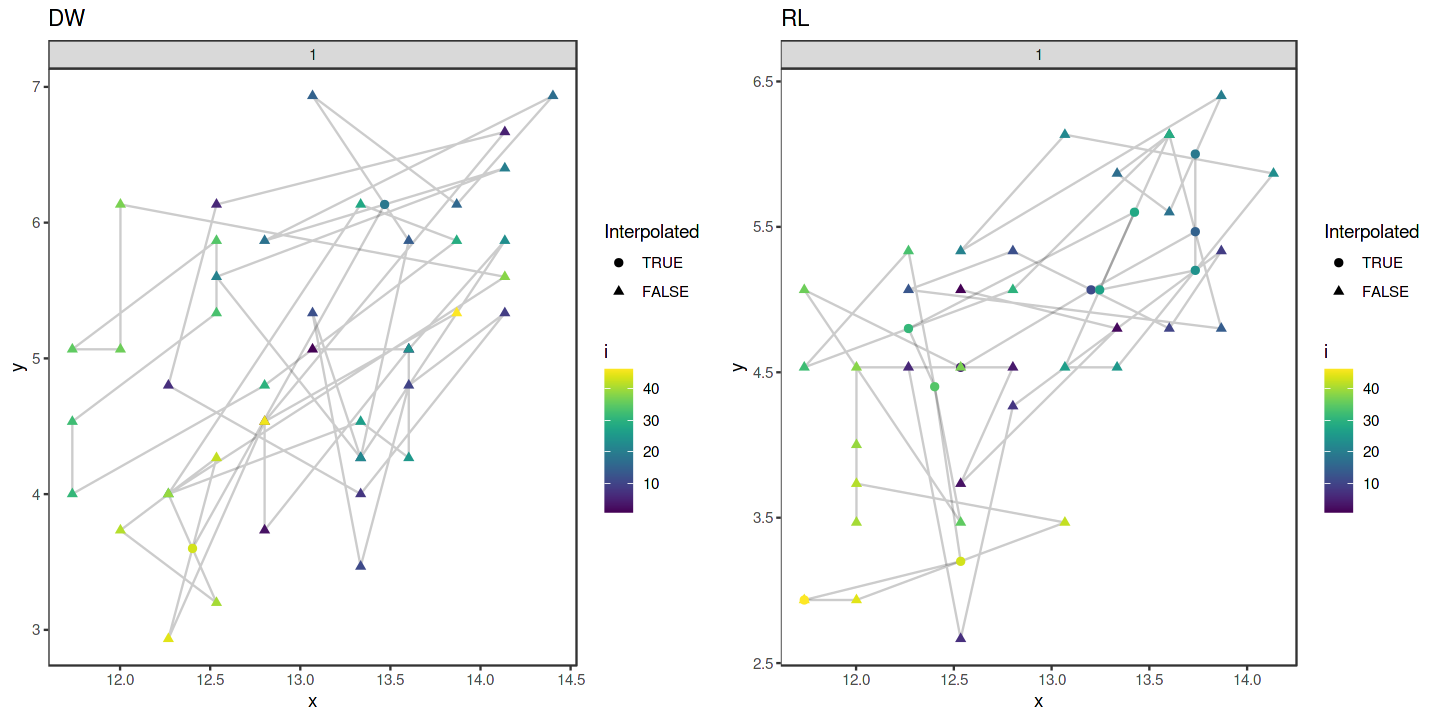

In [17]:
plot_3d_structures(coords_dw[file_id == 1], coords_rl[file_id == 1], "DW", "RL")
plot_xy_structures(coords_dw[file_id == 1], coords_rl[file_id == 1], "DW", "RL")

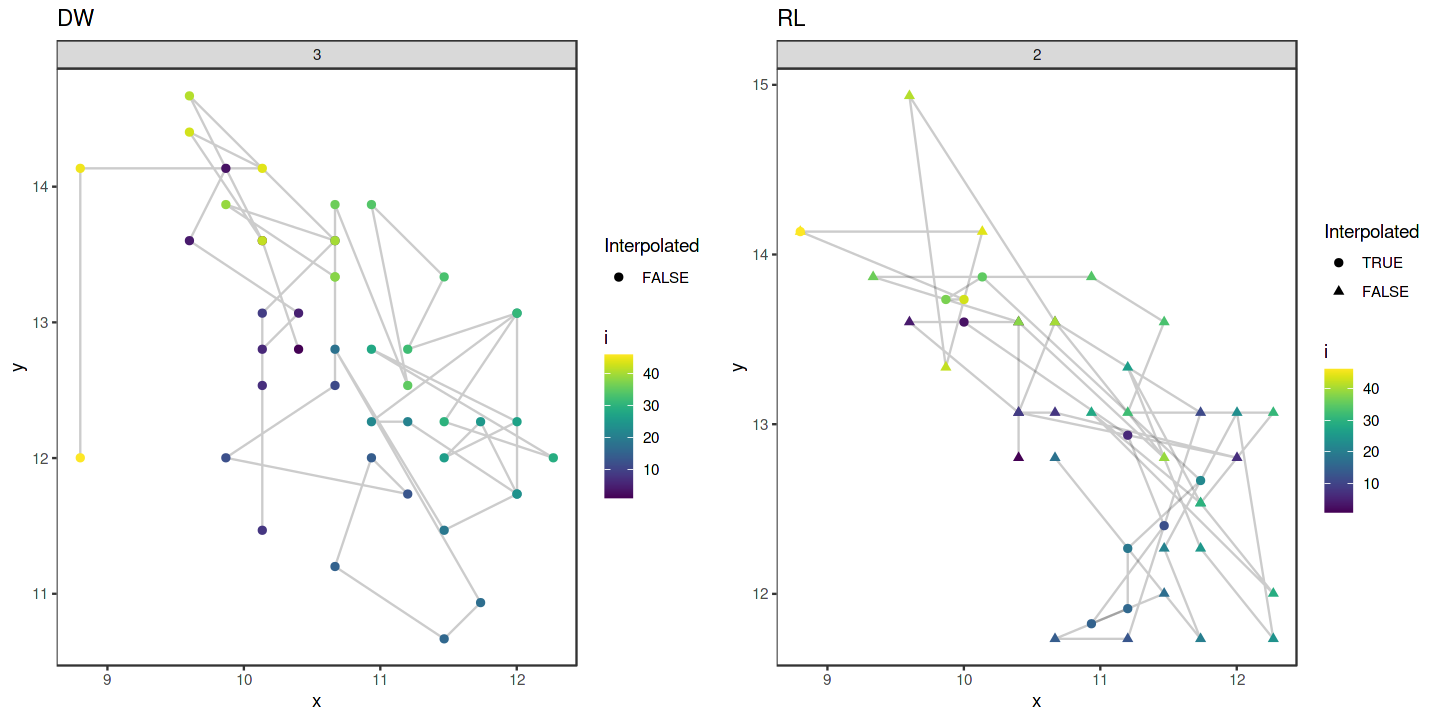

In [18]:
#plot_3d_structures(coords_dw[file_id == 2], coords_rl[file_id == 1], "DW", "RL")
plot_xy_structures(coords_dw[file_id == 3], coords_rl[file_id == 2], "DW", "RL")

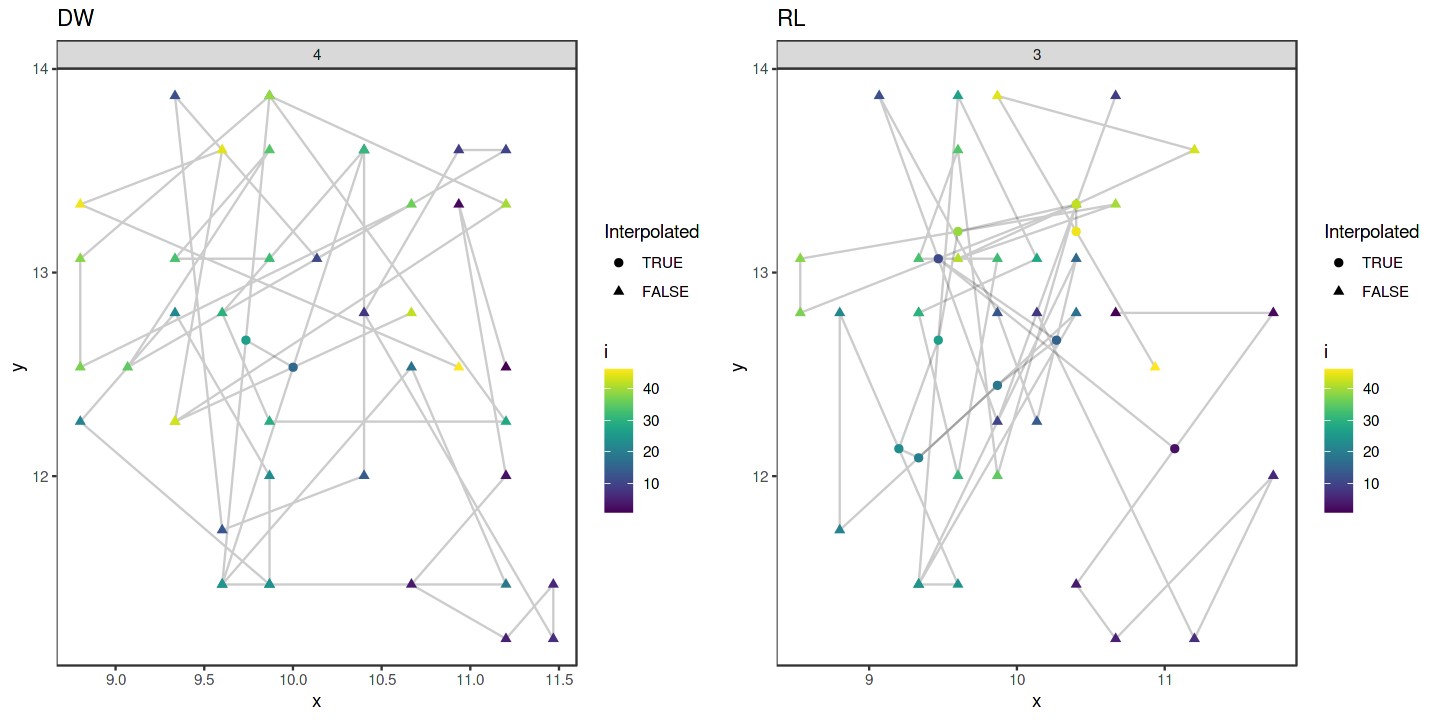

In [19]:
#plot_3d_structures(coords_dw[file_id == 2], coords_rl[file_id == 1], "DW", "RL")
plot_xy_structures(coords_dw[file_id == 4], coords_rl[file_id == 3], "DW", "RL")